In [1]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_train.npy")
Y_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_train.npy")

X_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_val.npy")
Y_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_val.npy")

X_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_test.npy")
Y_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_test.npy")

In [4]:
# Divide by the maximum of the training data set for that channel
for i in range(0,4):
    print(np.max(X_train[:,:,i]),np.max(X_val[:,:,i]),np.max(X_test[:,:,i]))
    s0 = np.max(X_train[:,:,i])

    X_train[:,:,i]=X_train[:,:,i]/s0
    X_val[:,:,i]=X_val[:,:,i]/s0
    X_test[:,:,i]=X_test[:,:,i]/s0
    print(np.max(X_train[:,:,i]),np.max(X_val[:,:,i]),np.max(X_test[:,:,i]))

3.088258983890954 2.6634138785625776 2.6445167286245352
1.0 0.8624321640301338 0.8563131338462618
132.61664460622106 132.6009265387161 132.59679020516216
1.0 0.9998814774152096 0.9998502872613174
132.73494374586366 132.72832561217737 132.7448709463931
1.0 0.9999501402306016 1.0000747896540978
5.074349442379182 5.074349442379182 5.074349442379182
1.0 1.0 1.0


In [5]:
# Switch the location of the time axis and channel axis because CNN layers in pytorch expect channels first
tX_train = np.moveaxis(X_train,2,1)
tY_train = Y_train

tX_val = np.moveaxis(X_val,2,1)
tY_val = Y_val

tX_test = np.moveaxis(X_test,2,1)
tY_test = Y_test

In [6]:
X_train.shape

(140082, 400, 4)

In [7]:
dat = X_val
ys = tY_val
i0 = np.min(dat[:,:,0],axis=1)
i1 = np.min(dat[:,:,1],axis=1)
i2 = np.min(dat[:,:,2],axis=1)
i3 = np.min(dat[:,:,3],axis=1)

s0 = np.max(dat[:,:,0],axis=1)
s1 = np.max(dat[:,:,1],axis=1)
s2 = np.max(dat[:,:,2],axis=1)
s3 = np.max(dat[:,:,3],axis=1)

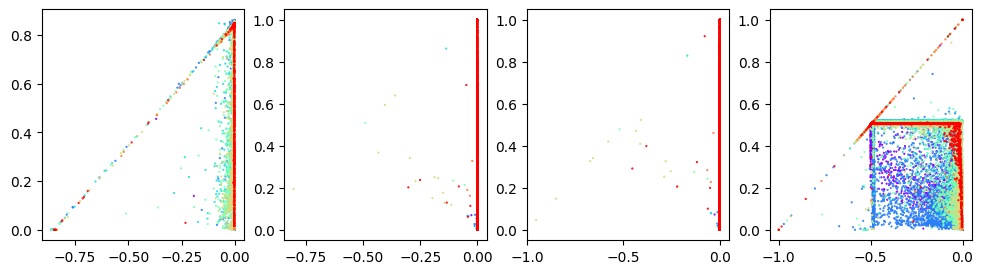

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].scatter(i0,s0,c=ys,cmap='rainbow',s=0.3)
axes[1].scatter(i1,s1,c=ys,cmap='rainbow',s=0.3)
axes[2].scatter(i2,s2,c=ys,cmap='rainbow',s=0.3)
axes[3].scatter(i3,s3,c=ys,cmap='rainbow',s=0.3)

## Set up the pytorch data loaders

In [9]:
class SP2Datasets(Dataset):
    def __init__(self,purpose,latent=False):

        if purpose == "train":
            self.X = tX_train
            self.Y = tY_train
        elif purpose == "val":
            self.X = tX_val
            self.Y = tY_val
        else:
            self.X = tX_test
            self.Y = tY_test
    def __len__(self):
        return int(self.X.shape[0])
    def __getitem__(self,idx):

        X = self.X[idx,:,:]
        Y = self.Y[idx]

        return X,Y

In [10]:
bs = 500
traindataset = SP2Datasets("train",bs)
valdataset = SP2Datasets("val",bs)
testdataset = SP2Datasets("test",bs)

In [11]:
# disable auto load the data in chunks from memory

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainloader = DataLoader(
    traindataset,
    batch_size=bs,
    shuffle = True,
    #num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

valloader = DataLoader(
    valdataset,
    batch_size=bs,
    shuffle = True,
    #num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

testloader = DataLoader(
    testdataset,
    batch_size=bs,
    shuffle = True,
    #num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)


#trainloader = DataLoader(traindataset, batch_size=bs, shuffle= True )
#valloader = DataLoader(valdataset, batch_size=bs, shuffle=True)
#testloader = DataLoader(testdataset, batch_size=bs, shuffle=True)


In [12]:
i = 0
j = 0
for data in trainloader:
    x,y=data

    #print(x.shape,y.shape)
    i = i+1
    j = j+x.shape[0]
print(i,j)

281 140082


In [13]:
st = 2
c1 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c2 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c3 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
c4 = Conv1d(in_channels=4,out_channels=4,kernel_size=4,stride=st,padding=1)
n_latent = 3
lin = Lin(100,n_latent)

In [14]:
x2 = c1(x.float())
x3 = c2(x2)
x4 = c3(x3)
x5 = c4(x4)
x6 = x5.view(-1,100)
print(x.shape,x2.shape,x3.shape,x4.shape,x5.shape,x6.shape)

torch.Size([82, 4, 400]) torch.Size([82, 4, 200]) torch.Size([82, 4, 100]) torch.Size([82, 4, 50]) torch.Size([82, 4, 25]) torch.Size([82, 100])


## Set up the model

In [15]:
class Encoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(Encoder, self).__init__()
        self.n_layers = 4
        self.n_steps = n_steps
        self.c1 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation1 = ReLU()
        self.c2 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation2 = ReLU()
        self.c3 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation3 = ReLU()
        self.c4 = Conv1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation4 = ReLU()
        self.lin = Lin(int(self.n_steps/self.n_layers),n_latent)

    def forward(self,x):

        x = self.c1(x)
        x = self.activation1(x)
        x = self.c2(x)
        x = self.activation2(x)
        x = self.c3(x)
        x = self.activation3(x)
        x = self.c4(x)
        x = self.activation4(x)
        x = x.view(-1,int(self.n_steps/self.n_layers))
        return self.lin(x)

class Decoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(Decoder, self).__init__()

        self.n_layers = 4
        self.n_steps = n_steps
        self.n_latent = n_latent
        self.n_channels = n_channels

        self.lin = Lin(n_latent,int(self.n_steps/self.n_layers))
        self.conv1 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation1 = ReLU()
        self.conv2 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation2 = ReLU()
        self.conv3 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation3 = ReLU()
        self.conv4 = ConvTranspose1d(in_channels=n_channels,out_channels=n_channels,kernel_size=4,stride=2,padding=1)
        self.activation4 = ReLU()
        self.lin2 = Lin(n_steps,n_steps)
        self.activation5 = ReLU()

    def forward(self,x):

        inp = x

        x = self.lin(inp)
        x = x.reshape(-1,self.n_channels,int(self.n_steps/self.n_layers/self.n_channels))
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.conv4(x)
        x = self.activation4(x)

        x = self.lin2(x)

        return x #self.activation5(x)

class SP2AutoEncoder(torch.nn.Module):
    def __init__(self,n_channels=4,n_steps=400,n_latent=10):
        super(SP2AutoEncoder, self).__init__()

        self.encoder = Encoder(n_channels=n_channels,n_steps=n_steps,n_latent=n_latent)
        self.decoder = Decoder(n_channels=n_channels,n_steps=n_steps,n_latent=n_latent)

    def forward(self,x):

        bs = x.shape[0]

        latent = self.encoder(x)

        reconstruction = self.decoder(latent) #+x

        return reconstruction,latent

In [16]:
def recon_loss(recon_x,x):
    mseloss = torch.nn.MSELoss()
    mse = mseloss(recon_x,x)

    return mse

In [17]:
def train(model,dataloader,criterion,device,epoch):
    model.train()

    for data in dataloader:
        x,y=data

        optimizer.zero_grad()

        xhat,latent = model(x.float())

        mseloss = recon_loss(xhat,x.float())

        loss = mseloss

        loss.backward()

        optimizer.step()

    return model
def test(model,dataloader,criterion,device):
    model.eval()
    correct = 0
    recon = 0

    with torch.no_grad():
        for data in dataloader:
            x,y=data

            xhat,latent = model(x.float())

            mse = recon_loss(xhat.float(),x.float())

            #correct = correct+loss
            nn = len(dataloader.dataset)
            recon = recon+mse

        return recon/nn

def inference(model,dataloader,device,n_latent=2):
    model.eval()
    dataset = dataloader.dataset
    print(len(dataset))
    bs = 500

    realx = np.zeros((len(dataset),4,400))
    predx = np.zeros((len(dataset),4,400))
    realclasses = np.zeros((len(dataset)))
    latentvars = np.zeros((len(dataset),n_latent))

    jj = 0
    i = 0

    for data in dataloader:

        x,y=data

        xhat,latent = model(x.float())

        bs = xhat.shape[0]
        if xhat is not(None):
            realx[jj:jj+bs,:]=x.cpu().detach().numpy().reshape(bs,4,400)
            predx[jj:jj+bs,:]=xhat.cpu().detach().numpy().reshape(bs,4,400)
            realclasses[jj:jj+bs]=y.cpu().detach().numpy().reshape(bs)
            latentvars[jj:jj+bs,:]=latent.cpu().detach().numpy().reshape(bs,n_latent)

            jj=jj+bs
            i = i+1
        else:
            break

    return realx,predx,realclasses,latentvars

In [18]:
init_lr = 1e-3
weight_decay = 1e-3
total_epochs = 200

# Learning rate strings so its in the correct format for the filenames
lrval='{:3.0e}'.format(init_lr)[0]
lrexp = '{:3.0e}'.format(init_lr)[4]

model = SP2AutoEncoder(n_latent=2)

# Check if there is a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# print(model)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [19]:
val_accur = []
train_accur = []

train_mse_recs = []
val_mse_recs = []

In [20]:
device

device(type='cpu')

In [21]:
e0 = 0
epochs = 60


for epoch in tqdm(range(e0,epochs)):
    mod = train(model,trainloader,criterion,device,epoch)
    train_mse = test(model,trainloader,criterion,device)
    val_mse = test(model,valloader,criterion,device)

    train_mse_recs.append(train_mse)
    val_mse_recs.append(val_mse)
    if epoch%10==0:
      print(f'Epoch: {epoch:03d}, Train MSE: {train_mse:.8e}, Val. MSE: {val_mse:.8e}')

  2%|▏         | 1/60 [00:31<30:44, 31.26s/it]

Epoch: 000, Train MSE: 5.59931395e-05, Val. MSE: 5.61695815e-05


 18%|█▊        | 11/60 [05:25<23:58, 29.37s/it]

Epoch: 010, Train MSE: 4.93640437e-06, Val. MSE: 4.99390035e-06


 35%|███▌      | 21/60 [10:21<19:37, 30.18s/it]

Epoch: 020, Train MSE: 4.56358202e-06, Val. MSE: 4.60992760e-06


 52%|█████▏    | 31/60 [15:14<14:10, 29.32s/it]

Epoch: 030, Train MSE: 4.42325654e-06, Val. MSE: 4.47373532e-06


 68%|██████▊   | 41/60 [20:09<09:17, 29.34s/it]

Epoch: 040, Train MSE: 4.19794742e-06, Val. MSE: 4.21825143e-06


 85%|████████▌ | 51/60 [25:01<04:22, 29.20s/it]

Epoch: 050, Train MSE: 4.13852331e-06, Val. MSE: 4.15886143e-06


100%|██████████| 60/60 [29:26<00:00, 29.44s/it]


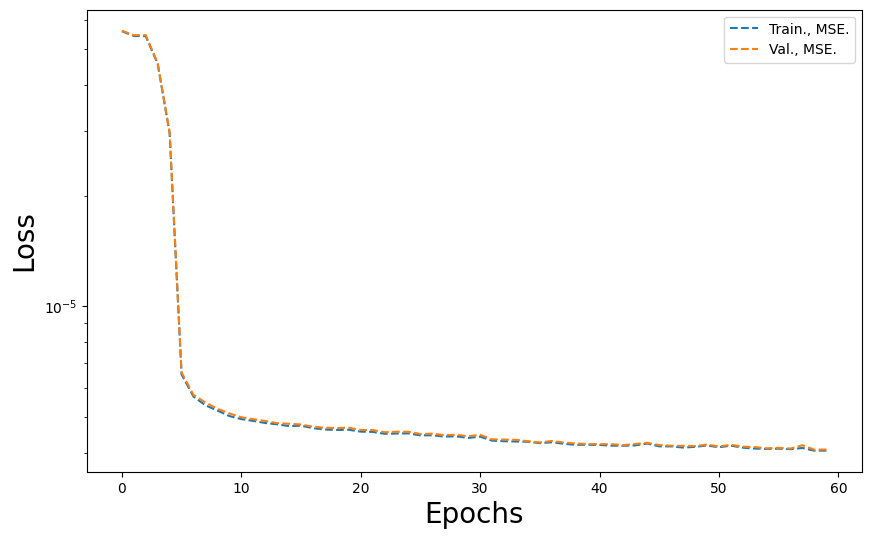

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_mse_recs, label='Train., MSE.',linestyle='dashed')
plt.plot(val_mse_recs,label='Val., MSE.',linestyle='dashed')
plt.yscale('log')
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.legend()
plt.show()

In [23]:
trainrealx,trainpredx,trainrealy,trainlatent=inference(model,trainloader,device)
valrealx,valpredx,valrealy,vallatent=inference(model,valloader,device)
testrealx,testpredx,testrealy,testlatent=inference(model,testloader,device)

#trainrealx --> what was being inputted to the vae
#testpredictedx --> 4 channels afte reconstructed from latent variables
#realy --> reall labels of the different aerosols (as a number from 0-7)
#testlatent --> the n_latent we set (2 in this case)
#for the 140,000 signals you ahve two points --> one for latent 1 and latent 2

140082
70041
70042


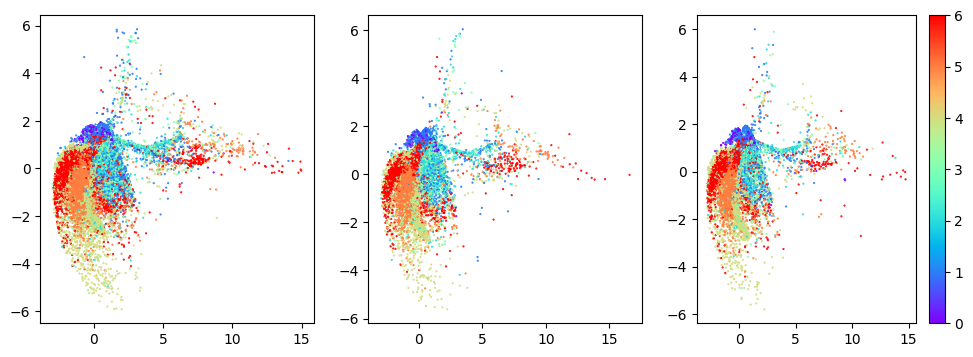

In [24]:
target_names=["FS","FSglyc","CFA","ATD","VA","Fe2O3","Fe3O4"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].scatter(trainlatent[:,0],trainlatent[:,1],c=trainrealy[:],cmap='rainbow',s=0.3)
axes[1].scatter(vallatent[:,0],vallatent[:,1],c=valrealy[:],cmap='rainbow',s=0.3)
ax2=axes[2].scatter(testlatent[:,0],testlatent[:,1],c=testrealy[:],cmap='rainbow',s=0.3)
cbar = plt.colorbar(ax2)
cbar.set_ticklabels=target_names

In [33]:
testrealy.shape

(70042,)

In [34]:
trainrealy.shape

(140082,)

In [36]:
X_test.shape

(70042, 400, 4)

In [40]:
Y_train.shape

(140082,)

In [41]:
Y_test.shape

(70042,)

In [61]:
trainrealy

array([3., 1., 3., ..., 6., 0., 2.])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


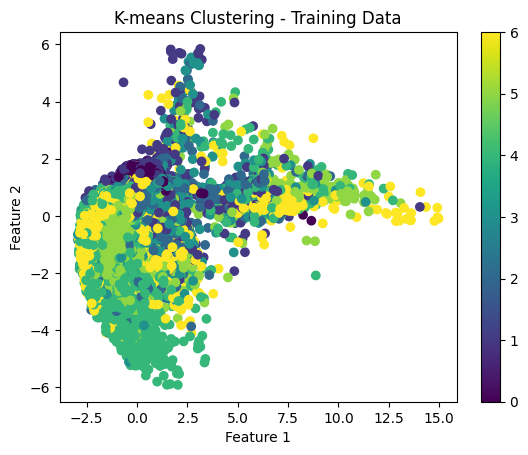

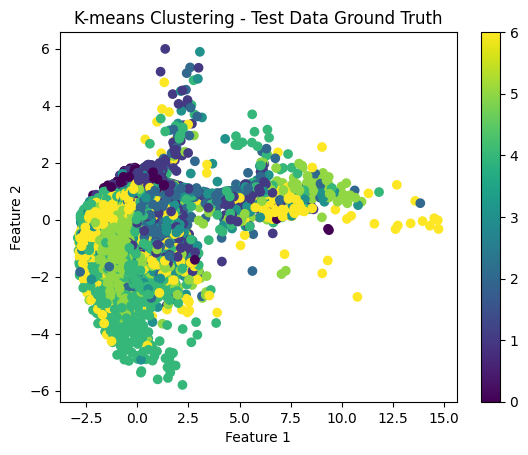

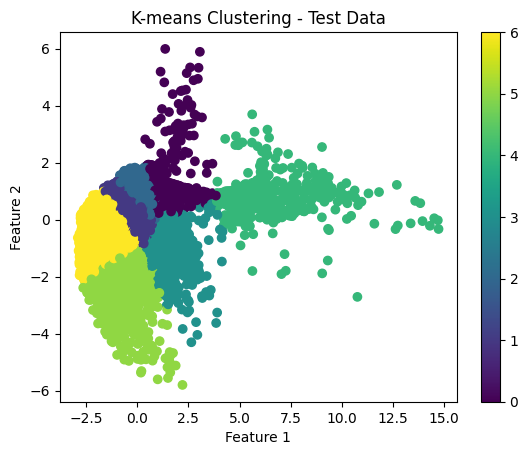

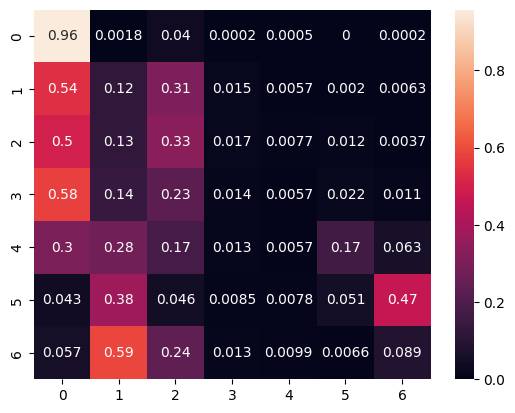

In [74]:
from sklearn.cluster import KMeans
def kmeans(X_train, X_test, train_cluster_labels, test_labels, num_clusters=7):

  # Initialize the k-means clustering model
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)

  kmeans.fit_transform(X_train)

  # Get the clustering labels to be used for the training data

  # Perform clustering on the test data
  test_cluster_labels = kmeans.predict(X_test)

  # Visualize the training data
  plt.scatter(X_train[:, 0], X_train[:, 1], c=train_cluster_labels, cmap='viridis')
  plt.title('K-means Clustering - Training Data')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.colorbar()
  plt.show()

  # Visualize the training data
  plt.scatter(X_test[:, 0], X_test[:, 1], c=test_labels, cmap='viridis')
  plt.title('K-means Clustering - Test Data Ground Truth')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.colorbar()
  plt.show()

  # Visualize the test data
  plt.scatter(X_test[:, 0], X_test[:, 1], c=test_cluster_labels, cmap='viridis')
  plt.title('K-means Clustering - Test Data')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.colorbar()
  plt.show()

  confusion_matrix = np.zeros((7, 7))

  for point, label, pred_cluster in zip(X_test, testrealy, test_cluster_labels):
    confusion_matrix[int(label)][int(pred_cluster)]+=1

  new_confusion_matrix = np.zeros((7,7))
  for i, row in enumerate(confusion_matrix):
    row_total = sum(row)
    for j, elem in enumerate(row):
      new_confusion_matrix[i][j] = elem/row_total

  sns.heatmap(new_confusion_matrix, annot=True)


kmeans(trainlatent, testlatent, trainrealy, testrealy, 7)

In [ ]:
#N = 4 and N = 6 there are 4 and 6 dimensions so its harder to see these in spaces
#Maybe look at confusion matrix what eprcentage of the variable A (Iron oxide) is in cluster 1, 2, 3, 4, 5, 6
#See if thats the same in the testing and training data set
#Maybe K-Means parametric is different
#training on one and another
#maybe you can do transform for the k - means (so maybe you can refit where the transform is) because data is distributed differently
#clusters mgiht not be put in right latent space
#k-means is not parametric because clustering is only dependent on value of data points rather thaan division within space that COuld be parametrized
#for every new point that you add, algorithmn would have to run agian and re-calculate the centers
#compare whats in the cluster and whats in the y_label to get a better understanding of how each particle is really distributed if its a strong match or not (heatmap from seaborn)
#pyro-ved gives you several different invariants to include
#how well distributed is the autoencoder
#separate latent spaces for each of the channels

#exploring pyroved and different invariants
#confusion matrix/seaborn heat map for distribution of point in a clsuter
#latent spaces on each of the channels so have 4 separate autoencoders (4 graphs)
#everything was divided by the maximum --> maybe potentially log scaletd
#separate two channels relatde to incadescene and two channels related to light (red and blue are like wavelength ranges. based on eye color - visible range of light)
#have two autoencoders --> one for the two incadescense channels (red and blue) and the two scattering channels channels (wavelengths of the lasers)

#0 : scattering channel
#1: blue channel
#2: red channel
#3 : position sensitive detector


#n-latent as well

#UMAP and TSNE
#UMap is a little more interpretable and better than tsne

In [ ]:
# import umap
# reducer = map.UMAP()
# Embedding = reducer.fit_transform(train_cluster_labels)
# plt.scatter(embedding[:, 0], embedding[:, 1],
#     c=[sns.color_palette()[x] for x in target_names.map({“FS”:0, “FSglyc”:1, “CFA”:2, “ATD”:3, “VA”: 4, “Fe203”, “Fe304”})])